# Overview

This week's curriculum is a little bit of a mixed bag. We'll cover topics that are not super-related, but both are _very useful_ (and there is some connection between them). The overview is

* Tricks for raw text (NLPP, Chapter 3) and finding the important words in a document (TF-IDF)
* Community Detection

In the first part, we will take a quick tour of NLPP's chapter 3, which is boring, but an amazing resource that you'll keep returning to. Then we'll talk about how we can use simple statistics & machine learning to get text to show us what it's all about. We will even do a little visualization. 

In the second part we will go back to network science, discussing community detection and trying it out on our very own dataset.

Video links
* Sune's community detection algorithm, for overlapping communities (that we're learning about today) is helping create break-throughs in brain science: https://news.iu.edu/stories/2020/10/iub/releases/19-neuroscientists-build-new-human-brain-network-model.html

# Processing real text (from out on the inter-webs)

Ok. So Chapter 3 in NLPP is all about working with text from the real world. Getting text from the internet, cleaning it, tokenizing, modifying (e.g., stemming, converting to lower case, etc.) to get the text in shape to work with the NLTK tools you've already learned about - and many more. 

In the process we'll learn more about regular expressions, as well as unicode; something we've already been struggling with a little bit will now be explained in more detail. 
> 
> **Video lecture**: Short overview of chapter 3 + a few words about kinds of language processing that we don't address in this class. 
> 

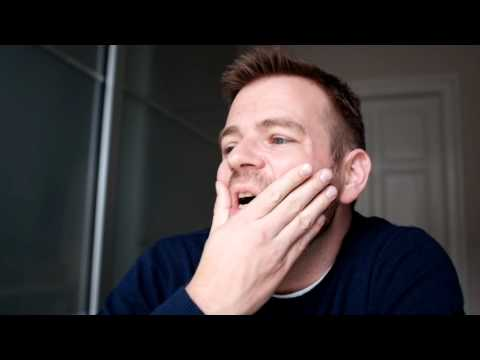

In [1]:
from IPython.display import YouTubeVideo, HTML, display
YouTubeVideo("Rwakh-HXPJk", width=800, height=450)

> *Reading*: NLPP Chapter 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.9, and 3.10\. It's not important that you go in depth with everything here - the key thing is that you *know that Chapter 3 of this book exists*, and that it's a great place to return to if you're ever in need of an explanation of regular expressions, unicode, or other topics that you forget as soon as you stop using them (and don't worry, I forget about those things too).
> 

In [140]:
import pandas as pd
from pathlib import Path
import re
import nltk
import numpy as np
from collections import Counter
import networkx as nx
import ast

During Week 6, we have downloaded the ZeldaWiki pages via the API and let nltk preprocessing it (by using `PlaintextCorpusReader` and `words()`). However, you might have noticed (especially when computing the frequency distribution with `FreqDist`) that the text was far from being clean. 

Today, we are going to preprocess the ZeldaWiki pages first by using a few methods from Chapter 3! 

> *Exercise 1* Preprocessing the ZeldaWiki text. Follow the bullets below for each character in your [character list](https://github.com/SocialComplexityLab/socialgraphs2021/blob/main/files/ZeldaBotW_nodes_w_attributes_enriched.csv):
>   * Read the file containing the character's page description.

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2021/main/files/ZeldaBotW_nodes_w_attributes_enriched.csv")

>   * Filter out the headers of sections by using `re.sub(pattern,'',DESCRIPTION_HERE)` (**hint** headers are in the form `== header name ==` where the number of `=` might vary.
>      *  **Note:** I found that there are many repetitions towards the end of pages in the sections "Locations", "Nomenclature", "See Also", and "Gallery". You can remove these sections from the description entirely (up to you).

>   * Tokenize your text with `WordPunctTokenizer()`
>   * Exclude characters names (since we're interested in the words, not the names)
>      * **Note 1** some of our characters have names that are made by multiple words, e.g., "Mo'a Keet", thus you might want to exclude these before tokenizing
>      * **Note 2** common enemy names can appear with Upper-, Lower-case, and plural forms, e.g., Bokoblin, bokoblin, bokoblins. It is up to you to decide whether you want to take care of these cases.
>   * Exclude punctuation and stop words.
>   * Set everything to lower case.
>   * Lemmatize your words with `WordNetLemmatizer()`
>   * Save your output for future use.
>
> **Note** *none of the above has to be perfect. It might not be easy to remove _all_ characters names. And there's some room for improvisation. In my own first run the results didn't look so nice, because some pages are very detailed and might contain lists of words as the one in the "See Also" section, whereas other pages are very short. For that reason, I added a few notes for you on how I decided to handle some of these cases. You could also choose to use the unique set of words from each page rather than each word in proportion to how it's actually used on that page for instance (there are pros and cons with both choices). Choices like that are up to you.*

In [32]:
import string
import json

week6_contents_dir = Path("week6_contents")
week7_contents_dir = Path("week7_cleaned_contents")

week7_contents_dir.mkdir(exist_ok=True)

tokenizer = nltk.WordPunctTokenizer()
lemmatizer = nltk.WordNetLemmatizer()

stopwords = set(nltk.corpus.stopwords.words())

character_names = set(df["Name"])
character_names = character_names | {c + 's' for c in character_names}

character_pattern = "|".join(character_names)

for content_path in week6_contents_dir.glob("*.txt"):    
    with open(content_path) as file:
        content_raw = file.read()

    content1 = re.sub(r"=+[\w\s]*?=+", '', content_raw)
    content2 = re.sub(character_pattern, '', content1, flags=re.IGNORECASE)
    content2 = content2.lower()
    tokens = tokenizer.tokenize(content2)
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if t not in stopwords]

    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    
    new_file_path = week7_contents_dir / f"{content_path.stem}.json"
    with open(new_file_path, 'w') as file_w:
        json.dump(lemmas, file_w)

    

> *Exercise 2* Frequency distribution. Now that we have preprocess the ZeldaWiki pages:
>   * join them all together and convert them with `nltk.Text()`
>   * use your code from Week 6, to create frequency distribution including the cumulative frequency plot for the 75 most common words. 
>   * How does your new distribution differ from the one you found in Week 6?

In [33]:
all_tokens = []
for json_file in week7_contents_dir.glob("*.json"):
    with open(json_file) as f:
        token_list = json.load(f)
    all_tokens += token_list   

In [34]:
text = nltk.Text(tokens)

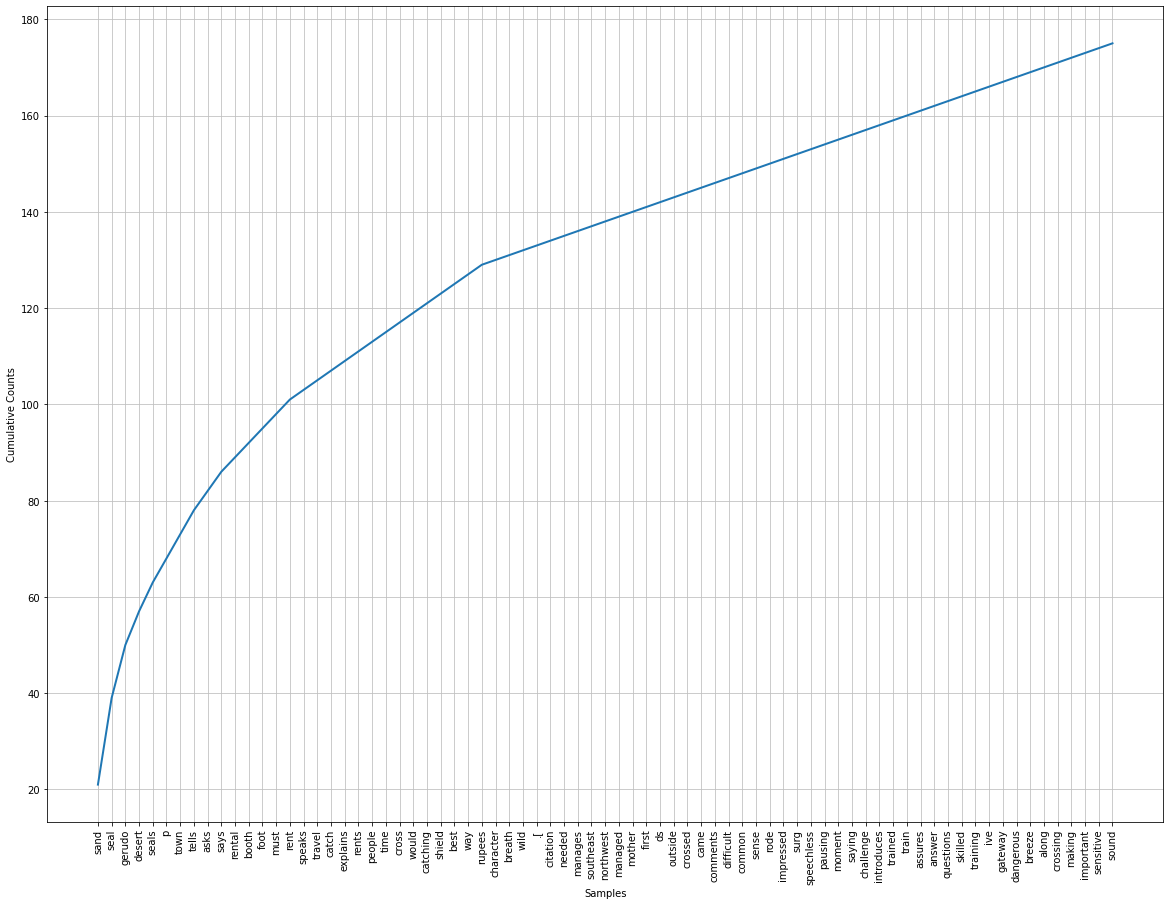

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [35]:
from nltk import FreqDist
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]
freq = FreqDist(text)
freq.plot(75, cumulative=True)

**Same shape, different words**

# Words that characterize the characters

In this section, we'll begin to play around with how far we can get with simple strategies for looking at text. 

The video is basically just me talking about a fun paper, which shows you how little is needed in order to reveal something highly interesting about humans that produce text. But it's important. Don't miss this one!

> **Video lecture**: Simple methods reveal a lot. I talk a little bit about the paper: [Personality, Gender, and Age in the Language of Social Media: The Open-Vocabulary Approach](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073791).  

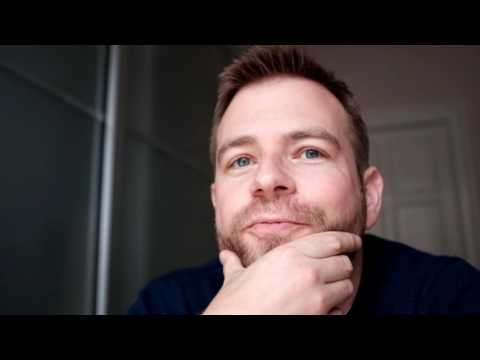

In [16]:
YouTubeVideo("wkYvdfkVmlI",width=800, height=450)

Now, we'll use the wordcloud visualization techniques from the paper/video to learn about the ZeldaWiki-pages we've downloaded. 

In the exercises below, we'll use a very simple weighting scheme called TF-IDF to find the important words for characters race.

### TF-IDF

> *Exercise 3*: TF-IDF and the characters' race.
> * Check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Explain in your own words the point of TF-IDF. 
>   * What does TF stand for? 
>   * What does IDF stand for?

TF - term frequency  
IDF - inverse document frequency

> * Since we want to find out which words are important for each *race*, we're going to create one document per race in BotW. Thus, combine the ZeldaWiki pages into one long list per race. 
> * Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within each race. 

In [120]:

def prepare_counters(groupby_field: str):
    field_to_top5words = dict()
    field_to_counter = dict()
    field_to_tf = dict()
    for field, dataframe in df.groupby(groupby_field):
        names = dataframe["Name"]
        field_counter = Counter()
        for n in names:
            json_file_path = week7_contents_dir / f"{n}.json"
            with open(json_file_path) as f:
                token_list = json.load(f)
            c = Counter(token_list)
            field_counter += c
        top5words = sorted([(word, count) for word, count in field_counter.items()], key=lambda t: t[1])[-5:]
        field_to_top5words[field] = top5words
        field_to_counter[field] = field_counter
        N = sum(v for v in field_counter.values())
        field_to_tf[field] = {word: count/N for word, count in field_counter.items()}
        
        
    return field_to_top5words, field_to_counter, field_to_tf
race_to_top5words, race_to_counter, race_to_word_to_tf = prepare_counters("Race")

In [121]:
list(race_to_top5words.items())[:10]

[('Ancient Orb',
  [('disappear', 1),
   ('ancient', 2),
   ('orb', 2),
   ('access', 2),
   ('shrine', 4)]),
 ('Bokoblin',
  [('enemy', 19), ('attack', 20), ('may', 23), ('red', 23), ('weapon', 25)]),
 ('Chuchu',
  [('red', 24), ('yellow', 33), ('blue', 38), ('chu', 41), ('jelly', 44)]),
 ('Dog',
  [('chest', 2), ('retriever', 3), ('stable', 3), ('since', 3), ('beast', 4)]),
 ('Dragon',
  [('spring', 5), ('drop', 6), ('shard', 6), ('scale', 6), ('dragon', 11)]),
 ('Gerudo',
  [('speaks', 119),
   ('tell', 135),
   ('say', 147),
   ('town', 188),
   ('gerudo', 400)]),
 ('Goron',
  [('brother', 39),
   ('rudania', 40),
   ('vah', 45),
   ('city', 66),
   ('goron', 130)]),
 ('Great Fairy',
  [('fountain', 6),
   ('upgrade', 6),
   ('armor', 6),
   ('fairy', 13),
   ('great', 14)]),
 ('Guardian',
  [('ancient', 13),
   ('shrine', 13),
   ('scout', 14),
   ('laser', 24),
   ('guardian', 32)]),
 ('Hinox',
  [('throw', 14), ('attack', 16), ('eye', 17), ('bomb', 34), ('x', 65)])]

>   * Describe similarities and differences between races.

Some races share the words (i.e. attack is common accross 7 races, appear in 5)

>   * Even though some terms might be descriptive, why are TFs not necessarily a good description of the races?

TFs not necessarily a good description of the races, because it has no way of telling if the word is common for all races or not.

> * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?

In [122]:
def count_word2idf(field_to_counter):
    D = len(field_to_counter)
    all_words = {w for counter in field_to_counter.values() for w in counter.keys()}
    word_to_idf = {}

    for word in all_words:
        document_occurences = sum(1 for counter in race_to_counter.values() if word in counter)
        word_to_idf[word] = np.log(D / document_occurences)
    return word_to_idf
word_to_idf = count_word2idf(race_to_counter)

> * We're ready to calculate TF-IDF. Do that for each race. 
>   * List the 5 top words for each race.
>   * Are these 5 words more descriptive of the race? If yes, what is it about IDF that makes the words more informative?
> * Normally, TF-IDF is used for single documents. What does TF-IDF tell us about the content of a single document in a collection.

In [126]:
def compute_tfidf_per_field(field_to_word_to_tf, word_to_idf):
    field_to_word_to_tfidf = {}

    for field, word_to_tf in field_to_word_to_tf.items():
        words_to_tfidf = {word: tf * word_to_idf.get(word) for word, tf in word_to_tf.items()}
 #           {word: tf[field].get(word, 0) * word_to_idf.get(word, 0) 
#                       for word, tf in field_to_tf.items()}
        field_to_word_to_tfidf[field] = words_to_tfidf
        
    return field_to_word_to_tfidf
race_to_word_to_tfidf = compute_tfidf_per_field(race_to_word_to_tf, word_to_idf)

In [127]:
for race, word_to_tfidf in race_to_word_to_tfidf.items():
    tfidf_top5 = sorted([(word, tfidf) for word, tfidf in word_to_tfidf.items()], key=lambda t: t[1])[-5:]
    print(race)
    print(tfidf_top5)
    print("\n")

Ancient Orb
[('affectioe', 0.07886938440740557), ('puffer', 0.07886938440740557), ('slidew', 0.07886938440740557), ('access', 0.09115620586522874), ('orb', 0.10220599718607448)]


Bokoblin
[('skull', 0.010108548401588585), ('red', 0.010461169900933948), ('horn', 0.010651365679607712), ('detached', 0.011412177513865406), ('boko', 0.02510679053050389)]


Chuchu
[('blob', 0.016628843925349794), ('yellow', 0.020252798033657052), ('chus', 0.028269034673094648), ('chu', 0.06817826009393416), ('jelly', 0.0731669132715391)]


Dog
[('wetland', 0.041779927688229836), ('puppy', 0.0457755120278379), ('barking', 0.0457755120278379), ('recoiled', 0.0457755120278379), ('retriever', 0.0915510240556758)]


Dragon
[('claw', 0.030861933028984784), ('rong', 0.04114924403864638), ('scale', 0.04528559300121198), ('dragon', 0.05869246595430504), ('shard', 0.06172386605796957)]


Gerudo
[('say', 0.012508046451366996), ('speaks', 0.01371657761722872), ('seal', 0.014701857645073538), ('gerudo', 0.01536871441706

### WordClouds

Setup. First you must set up your system. The most difficult thing about creating the wordcloud is installing the `WordCloud` module. It's available on GitHub, check out the page [**here**](https://github.com/amueller/word_cloud). 

If you're lucky, you can simply install using conda (and all dependencies, etc will be automatically fixed): 

    conda install -c conda-forge wordcloud
 
If you can't get that to work you can refer here https://anaconda.org/conda-forge/wordcloud. 
Also, maybe the comments below are helpful: 
 * The module depends on the Python library PIL. Use `conda` to install that before you do anything else.
 * On my system, the module needed the `gcc` compiler installed. If you're not already a programmer, you may have to install that. On Mac you get it by installing the [_command line tools_](http://osxdaily.com/2014/02/12/install-command-line-tools-mac-os-x/). On linux, it's probably already installed. And on Windows I'm not sure, but we'll figure it out during the exercises. 
 * Once that's all set up, you can use `pip` to install the `WordCloud` library, as [detailed on the GitHub page](https://github.com/amueller/word_cloud). But don't forget to use Anaconda's `pip`. 
 * There are examples of how to use the module online, see [here](http://sebastianraschka.com/Articles/2014_twitter_wordcloud.html) and [here](https://bioinfoexpert.com/2015/05/26/generating-word-clouds-in-python/). If you're interested, you can read about how the package was put together [here](http://peekaboo-vision.blogspot.dk/2012/11/a-wordcloud-in-python.html). 

> *Exercise 4* Plot the wordclouds
> * Get your lists ready for the word-cloud software
>    - The package needs a single string to work on. The way that I converted my lists to a string was to simply combine all words together in one long string (separated by spaces), repeating each word according to its TC-IDF, which is the Term Count (TF not normalized by len of document) and IDF you previously computed (rounded up to the nearest integer value). 
>    - The `wordcloud` package looks for collocations in real texts, which is a problem when you make the list as above. The recommended fix is to simply set `collocations = False` as an option when you run the package.
> * Now, create a word-cloud for each race. Feel free to make it as fancy or non-fancy as you like. Comment on the results. 
>
> Here, below you can find the wordclouds I have obtained for the races "Great Fairy" and "Dragon".

![Text](https://github.com/SocialComplexityLab/socialgraphs2021/blob/main/files/WrdCld-example.png?raw=True)

> *Exercise 5* 
>
> Now that you have code both for computing tf-idf and plotting wordclouds, you can try it out with the other metadata we have, i.e. role and gender.
>    * According to TF-IFD: what are the 5 top words for each role? and for each gender?
>    * Plot their wordclouds!
>

In [129]:
_, _, role_to_counter = prepare_counters("Role")
word_to_idf = count_word2idf(role_to_counter)
role_to_tfidf = compute_tfidf_per_field(role_to_counter, word_to_idf)

for field, tfidf in role_to_tfidf.items():
    tfidf_top5 = sorted([(word, tfidf_value) for word, tfidf_value in tfidf.items()], key=lambda t: t[1])[-5:]
    print(field)
    print(tfidf_top5)
    print("\n")


Ally
[('constructed', 0.00041720460380602944), ('timeline', 0.0004521682339264988), ('voe', 0.00046955931984674873), ('fulfilled', 0.0009739008115339974), ('ostracism', 0.0010608562411352472)]


Boss
[('sooga', 0.0010291450010942481), ('taran', 0.001801003751914934), ('kin', 0.001801003751914934), ('kohga', 0.001801003751914934), ('talus', 0.001804177296031645)]


Enemy
[('blob', 0.0009822193014466785), ('boko', 0.0010804412315913463), ('chus', 0.0016697728124593532), ('chu', 0.004027099135931382), ('jelly', 0.004321764926365385)]




In [130]:
_,  _, gender_to_counter = prepare_counters("Gender")
word_to_idf = count_word2idf(gender_to_counter)
gender_to_tfidf = compute_tfidf_per_field(gender_to_counter, word_to_idf)

for field, tfidf in gender_to_tfidf.items():
    tfidf_top5 = sorted([(word, tfidf_value) for word, tfidf_value in tfidf.items()], key=lambda t: t[1])[-5:]
    print(field)
    print(tfidf_top5)
    print("\n")

Female
[('nest', 0.0005806005119269157), ('ley', 0.0007741340159025542), ('barrack', 0.0008902541182879373), ('timeline', 0.0010063742206733203), ('voe', 0.001045080921468448)]


Male
[('entered', 0.0007136241151022281), ('bearing', 0.0007136241151022281), ('constructed', 0.0007481543142200779), ('fulfilled', 0.0017152660140445123), ('ostracism', 0.0019023859428493682)]


Unknown
[('blob', 0.0007316277894699719), ('boko', 0.0008047905684169691), ('chus', 0.0012437672420989522), ('chu', 0.0029996739368268847), ('jelly', 0.0032191622736678764)]




> **Note** When computing IDF for gender (that in our case is binary "Male", "Female"), if you use
>
> $$\log \left( \frac{N}{n_t+1} \right),$$
>
> $N = 2$ is the number of documents, and $n_t \in \{1,2\}$ is the number of documents containing the term $t$. This definition creates an issue as $IDF = 0$ when $n_t=1$, thus making TF-IDF behaving weirdly when having just two documents. As the $+1$ in the formula is added to avoid division by zero (when a word is not present in any of the documents), we can remove it and use 
>
> $$\log \left( \frac{N}{n_t} \right),$$
> 
> instead. This is possible if we compute TF-IDF only on the set of words in our documents.

In [105]:
# TODO: word clouds

# Community detection


Now that we have worked hard on text analysis, it is time to go back to our network! 

Before we begin, let's watch a great lecture to learn about communities. If you want all the details, I recommend you take a look at _Chapter 9_ in the _Network Science_ book ... but the video lecture below should be enough to get you started. 

**Note**: For this and the next exercise, work on the _undirected_ version of the network.

> **_Video Lecture_**: Communities in networks. 

You can watch the 2015 video [here](https://youtu.be/06GL_KGHdbE/).

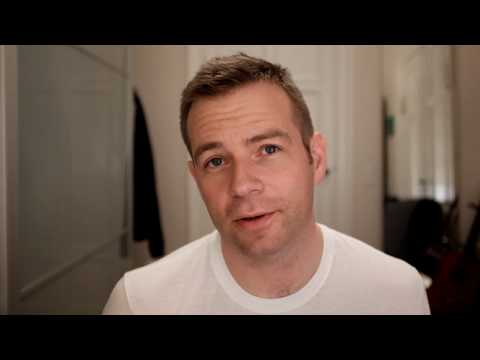

In [75]:
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

*Exercise 6*: Use the concept of modularity to explore how _community-like_ the races are.
> 
> * Explain the concept of modularity in your own words.

TODO

> * Consider the undirected version of the network (we consider the GCC as in the previous weeks).

In [152]:
df = pd.read_csv("heroes_with_attributes.csv")
df["links"] = df["links"].apply(lambda r: ast.literal_eval(r))

G = nx.DiGraph()
content_dir = Path("json_contents")

for index, row in df.iterrows():
    name = row["name"]
    gender = row["gender"]
    race = row["race"]
    typ = row["type"]
    with open(content_dir / f"{name}.txt") as f:
        content = f.read()
        word_count = len(re.findall(r"\b[\w']*?\b", content))
        
    G.add_nodes_from([(name, {"race": race, "type": typ, "gender": gender, "word_count": word_count})])
    
for index, row in df.iterrows():
    name = row["name"]
    links = row["links"]
    x = [(name, l) for l in links if name != l]
    G.add_edges_from(x)

x=[node for node, degree in G.degree if degree == 0]
G.remove_nodes_from(x)
largest_cc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_cc).to_undirected()

> * Create your own partition into communities, by dividing each character according to their race. 
> * **Calculate the modularity of this partition**. Modularity is described in the _Network Science_ book, section 9.4. Use **equation 9.12** in the book to calculate the modularity _M_ of the partitions described above. Are the races good communities? What about role and gender?
> * Would you expect this result in light of the overall analysis we have done in the previous weeks?

In [ ]:
def compute_modularity(G, partitions):
    

In [174]:
def modularity_per_field(field, use_nx=True):
    field_to_partition = {race: race_df["name"].tolist() for race, race_df in df.groupby(field)}
    partitions = [set(v) for k, v in field_to_partition.items()]
    partitions = [{p for p in partition if p in G.nodes()} for partition in partitions]
    partitions = [partition for partition in partitions if len(partition) > 0]
    if use_nx:
        return nx.algorithms.community.quality.modularity(G, partitions)
    else:
        

In [175]:
modularity_per_field("race")

0.11447147648781596

In [176]:
modularity_per_field("gender")

0.11509955021645737

In [180]:
modularity_per_field("type")

0.22194688002783897

The highest modularity score yields for the role of a character

In [163]:
for p1 in partitions:
    for p2 in partitions:
        if p1 != p2 and len(p1 & p2) > 0:
            print(p1, p2)

*Exercise 7*: Community detection.
> * Consider the BotW network (GCC as previously)
> * Use [the Python Louvain-algorithm implementation](http://perso.crans.org/aynaud/communities/) to find communities in the BotW network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for races as communities? What does this comparison reveal about them?
    >   * **Note**: This implementation is also available as Anaconda package. Install with `conda` as expained [here](https://anaconda.org/auto/python-louvain). 
    >   * You can also try the *Infomap* algorithm instead if you're curious. Go to [this page](http://www.mapequation.org/code.html) and search for 'python'. It's harder to install, but a better community detection algorithm.
>
> * Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 3). This time assign each node a different color based on their _community_. Describe the structure you observe.
> * Compare the communities found by your algorithm with the races:
>     * create a matrix $\mathbf{D}$ with dimension ($R \times C$), where $R$ is the number of races and $C$ is the number of communities. 
>     * set the entry $\mathbf{D}_{i,j}$ to be the number of nodes that race $i$ has in common with community $j$. 
>        - The matrix $\mathbf{D}$ is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). 
>     * Use the confusion matrix to explain further the modularity values found in Ex. 6 and the one of communities. How well the communities you've detected correspond to the labeled races of characters in BotW? (You can repeat the steps for gender and role).
> 
> *Optional* You might find communities that are much bigger than others. This is due to the cut that is done by the Louvain algorithm on the dendogram, resulting in some smaller communities to be merged together. What you can do to further detect these smaller communities is to re-apply the Louvain method on the bigger communities you found as follows:
>    * Create a subgraph (`G.subgraph(NODE_LIST)`) containing the nodes of a big community you want to split
>    * Re-run the Louvain algorithm to detect the communities in the subgraph
>    * Iterate over all communities you want to split.

**To be continued ...**. Next week, we'll put everything together by analysing the communities, their text, and by looking at their sentiment!